# Anchor box

In [14]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)  # 精简输出精度

In [15]:
import matplotlib.pyplot as plt

* 名詞釋義一下：  
  * boudning box: 一張圖片的 object 的 邊界框，這是 ground truth，就是人標出來的框. 
  * anchor box: 一張圖片，用特定方法，產出的一堆候選邊界框，這些邊界框的產出 depend on 不同方法，但生出來後，不保證這些邊界框有框到要辨認的物件. 

* object detection 通常會在一張圖裡面，生成很多 anchor box，然後：  
  * 判斷這些 box 裡面，有沒有我們感興趣的 object (e.g. 有沒有狗？ 有沒有貓？ ...)
  * 調整 anchor box 的邊界，讓他更靠近 ground truth 的 bounding box  
* 不同 object detection model，生成 anchor box 的方法可能不同，這邊介紹其中一種方法： `以每個 pixel 為中心，生成多個 縮放比 和 高寬比 不同的 anchor box`. 

* 提醒一下，這一章的內容可以著重在各個 function 的 input 和 output 就好

## 生成多個 anchor box

* 假設輸入影像的高度為 `h`, 寬度為 `w`，我們想生出的 anchor box，會這樣生：  
  * 縮放比 s (s = scale) 介於 0~1，例如我的 anchor box 的高，希望是原圖的 s 倍，那 anchor box 的高就是 h*s. 
  * 寬高比 r (r = ratio = w/h)，例如我的 anchbor box 的高如果是 $h_a$, 那我 anchor box 的寬就是 $h_a \times r$ 
  * anchor box 的 高： $h_a = hs$
  * anchbor box 的 寬： $h_w = hsr$

* 由此可知，只要給我 s 和 r，我就可以對某一個像素 (該像素的位置，就是中心)，生出一個 anchor box. 
* 那如果對單一個像素要生成多個 anchor box，我就可以選:
  * 縮放比= $s_1,\ldots, s_n$
  * 寬高比 = $r_1,\ldots, r_m$
  * 就可生成 nxm 個 bounding box. 
* 但實務上，這樣做的代價太高，所以最終只取 s1 和 所有 r, r1 和 所有s 的組合，也就是：$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$  
* 所以，一個像素，可以生出 n + m - 1 個 anchor box (而不是 nxm 個)
* 看一下 code

In [6]:
def multibox_prior(data, sizes, ratios):
    """生成以每個像素為中心，具有不同形狀的 anchor box
    args:  
      - data: torch 的 batch data，shape 為 (batch_size, num_of_channel, height, width)
      - sizes: 例如 [0.75, 0.5, 0.25]，就是ahchor box 的 height 要是原圖 height 的 0.75, 0.5, 0.25 倍, 
      - ratios: 例如 [1, 2, 0.5]，就是 anchor box 的 寬高比為 1 (正方形), 2 (胖矩形), 0.5 (瘦矩形) 
    returns:
      - tensor: (batch_size, anchor_box數量, 4)
    """
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]), sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

* 看個範例，假設我原始圖片如下：

561 728


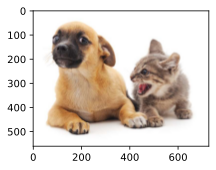

In [39]:
img = plt.imread('../img/catdog.jpg')
h, w = img.shape[:2]
print(h, w)
plt.imshow(img);

* 可以看到 高, 寬 分別是 561, 728
* 那我現在想對每一個 pixel，都生成 5 個 anchor box (3種 size x 3種 aspect ratio，只取部分組合，就得 3 + 3 - 1 = 5 種 anchor box)  
* 作法如下：

In [40]:
# 假的 batch 資料， batch size = 1, 然後是 預設高寬比的彩色圖片
X = torch.rand(size=(1, 3, h, w))

# 生成 anchor box
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])

# 看一下 shape
Y.shape

torch.Size([1, 2042040, 4])

* 從 size 有 3 個， ratios 有 3 ，可知每個 pixel 都要產出 5 個 anchor box (3+3-1 = 5)，以此題為例，這五個 (s,r) 分別是 (0.75, 1), (0.75, 2), (0.75, 0.5), (0.5, 1), (0.25, 1). 
* 所以 anchor box的總數量，為 $h \times w \times 5$ = 561x728x5 = 2042040. 
* 所以，如果要看第一個 anchor box 的座標，就這樣看：

In [41]:
Y[0,0,:]

tensor([-0.29, -0.37,  0.29,  0.38])

* 這四個數分別是 (xmin, ymin, xmax, ymax)，也就是 anchor box 左上角的座標，和左下角的座標  
* 為啥是小數？ 
  * 因為原圖的寬和高都先 re-scale 到 1，所以原圖的左上角是 (0,0)，右下角是 (1,1)  
  * 所以，如果 anchor box 的 (x, y) = (0.2, 0.7)，他的意思是，他在原圖的 (0.2 x width, 0.7x height) 的地方  
  * 所以，這組座標如果要拿去畫圖，標框框，會先做 scale，例如這樣做： `this_anchor_box_coord` * (w, h, w, h) ，就可以轉回原圖的座標. 
  * 那...為何要這麼麻煩？ 因為 ssd 在做的時候，他會把原圖，一路縮小成不同尺寸的 feature map，然後在這些尺寸的 feature map 上，生成 anchor box，再把這些 anchor box, mapping 到原圖。所以如果我的 anchor box 都是用比例，我就很方便的可以 mapping 回最一開始的原圖：只要乘上原圖的高寬就好。
* 為啥有負號？  
  * 現在的座標系統，左上角是 (0,0)，y往下為正，x往右為正。所以如果看到 (xmin, ymin) = (-0.29, -0.37)，那表示這個 anchor box 的左上，已經超過原圖了，他是從原圖原點(0,0)的左上角開始框的

* 又了上面的練習，就可以任意去探索某一個 anchor box 的 4 個座標點. 
* 但有個麻煩的地方就是，我如果想看原圖 (x,y) = (250, 250) 這個位置的 pixel，他生出的 5 個 anchor box 是多少，我就很難找到. 
* 所以，我們可以做個 reshape，再去找：

In [42]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, :, :]

tensor([[ 0.06,  0.07,  0.63,  0.82],
        [ 0.15,  0.20,  0.54,  0.70],
        [ 0.25,  0.32,  0.44,  0.57],
        [-0.06,  0.18,  0.75,  0.71],
        [ 0.14, -0.08,  0.55,  0.98]])

* 這樣，就找出他的 5 個 anchor box 的位置  
* 我們可以再寫個函數來畫圖：

In [44]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """顯示所有 anchor box
    args:  
      - axes: 原圖。i.e. 用 fig = plt.imshow(img) ，所得的 fig.axes
      - bboxes: 2d-tensor，shape 為 (幾個anchor_box, 4個coordinate)，記得，這邊的 scale 要轉回原圖的 scale了，所以原始座標要乘上原圖高寬
      - labels: 要備註該框框所用的文字. 
      - colors: 就 color
    return:
      - 標好框框和備註文字的圖片
    """
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [35]:
bbox_scale

tensor([561, 728, 561, 728])

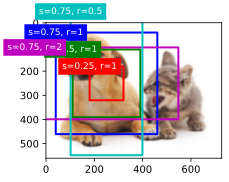

In [45]:
bbox_scale = torch.tensor((w, h, w, h))
fig = plt.imshow(img)
show_bboxes(
    fig.axes, 
    boxes[250, 250, :, :] * bbox_scale,
    ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2','s=0.75, r=0.5']
)

## IoU (Intersection of Union)

* 我們可以這樣計算兩個 bounding box 的重疊比例：
  - 已知 *Jaccard coefficient* 可以衡量兩個 set 之間的相似性
  - 给定集合$\mathcal{A}$和$\mathcal{B}$，他们的杰卡德系数是他们交集的大小除以他们并集的大小： $J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$

* 把一個 bounding box 想成一個集合，裡面的 pixel 就是他的 elemet，那 IoU 的圖示就會變成：  

![交并比是两个边界框相交面积与相并面积之比。](../img/iou.svg)

* code 在這：

In [54]:
#@save
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比
    args:
      - boxes1: ground truth 的 bounding boxes, shape 為 (bounding_box數量, 4個座標)
      - boxes2: anchor boxes, shape 為 (anchor_box數量, 4個座標)
    return:
      - tensor: shape 為 (幾個bounding_box, 幾個anchor_box)，也就是算出給定bounding box下，所有anchor box和他的IoU
    """
    
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

* 來個例子：

In [52]:
boxes1 = torch.tensor([[0.0, 0.0, 1.0, 1.0]])
boxes2 = torch.tensor([[0.5, 0.5, 1.5, 1.5]])
box_iou(boxes1, boxes2)

tensor([[0.14]])

* 這個 0.14 怎麼來的？ 交集面積是 $0.5^2 = 0.25$，聯集面積是 $1+1-0.25=1.75$，所以 $IOU = 0.25/1.75 = 0.14$

* 而且，這個 function 可以直接幫你算出，anchor box 和 所有 bounding box 的 IoU，例如：

In [53]:
ground_truth = torch.tensor([[0.1, 0.08, 0.52, 0.92],
                             [0.55, 0.2, 0.9, 0.88]]) # ground truth 有 2 個 anchor box
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], 
                        [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]]) # anchor box 有 3 個

box_iou(ground_truth, anchors)

tensor([[0.05, 0.14, 0.00, 0.00, 0.00],
        [0.00, 0.00, 0.57, 0.21, 0.75]])

* 可以看到，以第一個 ground truth box 為基底時，5 個 anchor box 和他算 IoU 的結果; 以及以第二個 ground truth box 為基底時，5 個 anchor box 和他算 IoU 的結果

## 製作 training set 的 anchor box & label

* 在 object detection 的時候，原始 training set 的 label 是用 data.frame 的形式定義的。每一個 row 是 file_name + bounding_box_id 的組合。  
* 也就是說，第一張圖，如果裡面有 3 個物件 (e.g. 2隻狗, 1隻貓)，那他會用五列來描述，然後每一列的資訊大概長這樣 [file_name, label, bbox_xmin, bbox_ymin, bbox_xmax, bbox_ymax]. 
* 也就是說，他會跟你說這一張 image，在這個 bounding box(左上的點, 右下的點)，他的 label 是 0 or 1 or 2 or ...  
* 所以，最小單位是 file_name + bounding_box_id. 
* 但真的在做 training 時，最小單位其實是 file_name + anchor_box_id，所以，我需要利用 bounding box 的資訊，把 class label 給 assign 到 anchor box上，這就是這邊要做的事. 
* 先講結論，最後我希望能做出這種表：  


| file_name | anchor_box_id | nearest_bounding_box_id | IoU | class_label    | mask      | offsets                |
|-----------|---------------|-------------------------|-----|----------------|-----------|------------------------|
| A.png     | A_a_1         | A_b_2                   | 0.8 | 2              | [1,1,1,1] | [0.2, 0.3, -0.1, -0.6] |
| A.png     | A_a_2         | A_b_1                   | 0.3 | 0 (background) | [0,0,0,0] | [0, 0, 0, 0]           |
| ...       | ...           | ...                     | ... | ...            | ...       | ...                    |
| Z.png     | Z_a_5         | Z_b_1                   | 0.6 | 1              | [1,1,1,1] | [-0.3, 0.2, 0.5, 0.2]  |

* 以第一列為例  
  * 我現在是 A.png 這張影像中，的第一個 anchor box (代號是 A_a_1, a=anchor的意思)  
  * 我拿這個 anchor box，去和 A.png 中的所有 ground_truth bounding box 算 IoU，並取出 IoU 最大的，把它叫做 nearest_bounding_box，然後找出來是 A_b_2 這個 bounding box(b=bounding box, 2=class label)。
  * 這個 nearest bounding box 的 IoU 是 0.8，因為他大於預設的 IoU threshold (0.5)，所以我就取他當代表。A_b_2 的 class_label 是 2，我現在就 assign 到 A_a_1 這個 bounding box 上，所以現在 A_a_1 的 class label 是 2 了. 
  * 接著，我拿 A_a_1 的座標 (cx, cy, width, height) 去和 A_b_2 的座標 (cx, cy, width, height) 做相減 (bounding - anchor)，得到 4 個座標點的 offsets 為 0.2, 0.3, -0.1, -0.6。所以我知道，只要拿 anchor box + offsets，就可以得到真實的 bounding box. 
  * 至於 mask，就是如果此 anchor box，有找到對應的 bounding box，那 mask 就會是 [1,1,1,1]，否則會是 [0,0,0,0]。這會用在等等 loss 的計算上。  
* 再來看第二列：
  * 我現在是 A.png 這張影像中，的第二個 anchor box (代號是 A_a_2, a=anchor的意思)  
  * 我拿這個 anchor box，去和 A.png 中的所有 ground_truth bounding box 算 IoU，並取出 IoU 最大的，把它叫做 nearest_bounding_box，然後找出來是 A_b_1 這個 bounding box(b=bounding box, 1=class label)。
  * 這個 nearest bounding box 的 IoU 是 0.3，因為他小於預設的 IoU threshold (0.5)，所以我不認為 anchor box 足以當此 bounding box 的代言人。所以，class label 不能繼承這個 bouding box，而是給他 0 這個背景類代號。  
  * 因為此 anchor box 屬於背景累了，所以我也不需要去算他和 bounding box 的 offsets 了，所以 offsets 全補 0
  * 至於 mask，因為此 anchor box，沒有找到對應的 bounding box，所以 mask 就會是 [0,0,0,0]。這會用在等等 loss 的計算上。  

* 截至現在，我們才把真正的 training set 該有的 label 都補好了。
* 至於，後續如何做訓練呢？ 我們會這樣做：  
  * 把 A.png 餵進來，會生出該影像的所有 anchor box (與上表會一一對應，因為 anchor box 的生成是給定的方法，沒有隨機性)
  * 在 A_a_1 這個 anchor box 中，模型會預測出 pred_class_probability (e.g. [0, 0.1, 0.9]，表示背景類的可能性是0, class = 1 的可能性是 0.1, class = 2 的可能性是 0.9)，模型也會預測出 4 個 offsets (e.g. [0.7, 0.1, -0.4, -0.2])  
  * (至於這個 anchor box 的座標，並沒有考慮進去，因為資訊已經存在在 label 時的 offsets 裡面了，我們是去預測 offsets，不是預測 anchor box 的座標)  
  * 接著，計算 class 的 entropy loss，以及 offsets 的 L1 loss，就得到兩個分數. 
  * 如果 class_label = 0 (背景類)，那 offsets loss 就不計算了，所以 mask 就是用在這個地方，offsets_loss =  mask * |label_offsets - pred_offsets|
  * 一路該 batch 的 所有影像的所有 anchor box 都跑完，就得到所有的 class loss 和 offsets loss，再把他們兩個直接相加，就得到 total loss. 
  * 我們在對這個 loss 取 gradient，更新參數，最終完成訓練。
* 至於，未來如何做預測呢？ 我們會這樣做：  
  * 把 new.png 這個影像餵進來. 
  * 先幫他生成 q 個 anchor box  
  * 對每個 anchor box，透過模型，預測出 pred_class_probability，和 4 個 offsets. 
  * 例如第一個 anchor box，他的 pred_class_probability = [0, 0.1, 0.9]，那我就說這個 box 裡面有 class = 2 的可能性有 0.9
  * 接著，我把這個 anchor box 加上 我預測出來的 4 個 offsets，就得到最終版的 anchor box。我就把這個座標畫在圖上，框出的區域，標註他是 class = 2，且可能性為 0.9. 
  * 但實際在做的時候，不會把所有 anchor box 都畫上去，實際在做的時候是這樣做的：  
    * 先濾掉 predict class 為背景類的框. 
    * 在濾掉 predict class 的 probability < threshold 的框 (因為表示這些框，他也不是很有信心能預測出正確的類別). 
    * 剩下的框，利用 Non-maximum supression，濾掉多餘的框. 
    * 最後，才對剩下的框，做剛剛的事情
* Non-maximum supression 的做法，這張圖太清楚了 (擷取自 [這裡](https://chih-sheng-huang821.medium.com/%E6%A9%9F%E5%99%A8-%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92-%E7%89%A9%E4%BB%B6%E5%81%B5%E6%B8%AC-non-maximum-suppression-nms-aa70c45adffa)):  

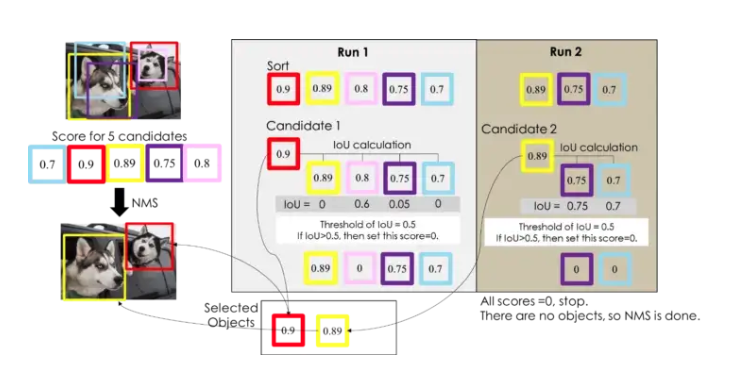

* 現在回過頭來，把 label 要做的事做完吧. 
* 首先，對於 assign bounding box 的資訊到 anchor box，他是分兩階段：  
  * 第一階段，用剛剛上面提到的做法，每個 anchor box，先去找 nearest bounding box (用 IoU找)，找到後，如果 IoU > threshold，就認可此 anchor box 可以當此 bounding box 的代言人，就把 class 繼承過來， offsets 算一算. 
  * 第二階段，是為了避免 anchor box 剛好都漏抓到某一類的 bounding box (e.g. 所有生出來的 anchor box，剛好和狗狗類的 bounding box 的 IoU 都 < threshold)，所以用了以下這招，來把資訊補齊：

![将真实边界框分配给锚框。](../img/anchor-label.svg)

* 講解一下這張圖怎麼看
* 给定图像，假设锚框是$A_1, A_2, \ldots, A_{n_a}$，真实边界框是$B_1, B_2, \ldots, B_{n_b}$，其中$n_a \geq n_b$。例如$n_a = 9$, $n_b=4$, 如上圖
* 让我们定义一个矩阵$\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$，其中第$i$ row、第$j$ column 的元素$x_{ij}$是锚框$A_i$和真实边界框$B_j$的IoU。
* 该算法包含以下步骤：
  1. 在矩阵$\mathbf{X}$中找到最大的元素，并将它的行索引和列索引分别表示为$i_1$和$j_1$。然后将真实边界框$B_{j_1}$分配给锚框$A_{i_1}$。这很直观，因为$A_{i_1}$和$B_{j_1}$是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中${i_1}^\mathrm{th}$行和${j_1}^\mathrm{th}$列中的所有元素。
  2. 在矩阵$\mathbf{X}$中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为$i_2$和$j_2$。我们将真实边界框$B_{j_2}$分配给锚框$A_{i_2}$，并丢弃矩阵中${i_2}^\mathrm{th}$行和${j_2}^\mathrm{th}$列中的所有元素。
  3. 此时，矩阵$\mathbf{X}$中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵$\mathbf{X}$中$n_b$列中的所有元素。此时，我们已经为这$n_b$个锚框各自分配了一个真实边界框。

* 來看 code 吧：

In [55]:
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框
    args:
      - ground_truth: shape 為 (幾個bounding_box, 4個coordinates)，所以他是對一張image做事，不是對batch_size張images做事. 
      - anchors: shape 為 (幾個anchor_box, 4個coordinates)
    return:
      - anchors_bbox_map: 一個 list，說明每個anchor box 對應到哪個 class label: 
    """
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于 第i個row, 和第j個col 的元素 x_ij 是 锚框i 和 真实边界框j 的 IoU
    jaccard = box_iou(anchors, ground_truth) # (num_anchors, num_gt_boxes) 的矩陣，每個 element 都是對應的 IoU
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device) # 如果有 5 個 anchor box，這邊就是先生成 [-1, -1, -1, -1, -1]，表示都背景類
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1) # 把每個 anchor box 中，max IoU 取出。例如第一個 anchor box，他和狗的 IoU 最大，我就取狗的 IoU 出來。 indices 是指 which max，以狗為例，就是 0;
                                                  # 範例結果如： max_ious -> tensor([0.05, 0.14, 0.57, 0.21, 0.75]); indices -> tensor([0, 0, 1, 1, 1]), 即狗狗貓貓貓
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1) # e.g. tensor([2,4])，就第 2 和 4 的 IoU > 0.5
    box_j = indices[max_ious >= 0.5] # 取出 indices 的第 [2,4] 的 element，所以結果是 [1,1], 就是貓貓
    anchors_bbox_map[anc_i] = box_j # anchor_bbox_map 本來是 [-1, -1, -1, -1, -1]，表所有 anchor box 都是背景，現在把第 2 & 4 個 element，補進 box_j，所以現在是 [-1, -1, 1, -1, 1]，背景,背景,貓,背景,貓
    col_discard = torch.full((num_anchors,), -1) # 5 個 anchor box，所以是 [-1, -1, -1, -1, -1]
    row_discard = torch.full((num_gt_boxes,), -1) # 2 個 bounding box，所以是 [-1, -1]
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard) # tensor(9), 第9個element有最大的IoU
        box_idx = (max_idx % num_gt_boxes).long() # 第 9 個 element，對應到的是第1個 ground_truth box，所以這邊 box_idx = 1 
        anc_idx = (max_idx / num_gt_boxes).long() # 第 9 個 element，對應到的是第4個 anchor box，所以這邊 anc_idx = 4
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

* 看一下範例：

In [113]:
ground_truth = torch.tensor([[0.1, 0.08, 0.52, 0.92],
                             [0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], 
                        [0.15, 0.2, 0.4, 0.4],
                        [0.63, 0.05, 0.88, 0.98], 
                        [0.66, 0.45, 0.8, 0.8],
                        [0.57, 0.3, 0.92, 0.9]])
box_iou(anchors, ground_truth)

tensor([[0.05, 0.00],
        [0.14, 0.00],
        [0.00, 0.57],
        [0.00, 0.21],
        [0.00, 0.75]])

* row 是 anchor box, column 是 bounding box，數值是 IoU. 
* 所以照前面的算法講解， code 是這樣進行：  
  * 第一階段：每個 anchor box 先找出離他最近的 bounding box，也就是 arg max IoU by row。  
    * 第一列，和他最近的是第1個column，但因為IoU < threshold = 0.5，所以不 assign class label 給他. 
    * 第二列，和他最近的也是第1個column，也因為 IoU < threshold 所以不 assign class label給他 
    * ...
    * 最終第三列和第五列，都 assign label class = 1 給他們，所以第一階段結束，5個anchor box 的結果是 [-1, -1, 1, -1, 1]，-1表background, 1表cat(第2個column/bounding box)  
  * 第二階段，用上面的圖解，先選到右下角的0.75，把label class assign 給第五列，在選到左上角的0.14，把label class = 0 assign 給第二列. 
  * 所以最終，第二階段有補足第一階段結束後，沒有 anchor box 會抓到 class = 0 的不足  
* 來確認算出來的結果和上面講得一樣：

In [115]:
assign_anchor_to_bbox(ground_truth, anchors, anchors.device)

tensor([-1,  0,  1, -1,  1])

## 製作 offsets

* 现在我们可以为每个锚框标记类别和偏移量了。  
* 假设一个锚框$A$被分配了一个真实边界框$B$。
* 一方面，锚框$A$的类别将被标记为与$B$相同。
* 另一方面，锚框$A$的偏移量将根据$B$和$A$中心坐标的相对位置以及这两个框的相对大小进行标记。
* 鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量。
* 在这里，我们介绍一种常见的变换。
* 给定框$A$和$B$，中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$。我们可以将$A$的偏移量标记为：

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

* 其中常量的默认值为 $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$ ， $\sigma_w=\sigma_h=0.2$。
* 这种转换在下面的 `offset_boxes` 函数中实现。


In [56]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

* 如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为“背景”（background）。
* 背景类别的锚框通常被称为“负类”锚框，其余的被称为“正类”锚框。
* 我们使用真实边界框（`labels`参数）实现以下`multibox_target`函数，来 **标记锚框的类别和偏移量**（`anchors`参数）。
* 此函数将背景类别的索引设置为零，然后将新类别的整数索引递增一。


In [65]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框
    args:
      - anchors: shape 為 (batch_size(i.e. 幾張images), 幾個anchor_box, 4個coordinate)
      - labels: ground truth 的 bounding box 資訊，shape 為 (batch_size(i.e. 幾張images), 幾個bounding_box, 4個coordinate)
    return:
      - bbox_offset: 每張圖每個anchor box與assign到的bounding box 之間的 offsets, shape 為 (batch_size, anchor_box個數x4(cx,cy,height,width的offsets))
      - bbox_mask: 該圖 該anchor_box 是否需要計算 offset, mask=0表示該anchor box沒有assign到bounding box, 所以不用算offsets, mask = 1 表示該anchor box有assign到bounding box，所以要算 offsets
                   shape 為 (batch_size, anchor_box個數x4(4個coordinate對應的mask，不需要算就4個0，需要就4個1)
      - class_labels: 該圖該anchor_box對應到的class label, 0表背景, 1,2,...,c表類別。shape為 (batch_size, anchor_box個數)
    """
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，我们标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

* 让我们通过一个具体的例子来说明锚框标签。
* 我们已经为加载图像中的狗和猫定义了真实边界框，其中第一个元素是类别（0代表狗，1代表猫），其余四个元素是左上角和右下角的$(x, y)$轴坐标（范围介于0和1之间）。
* 我们还构建了五个锚框，用左上角和右下角的坐标进行标记：$A_0, \ldots, A_4$（索引从0开始）。
* 然后我们 **在图像中绘制这些真实边界框和锚框**。

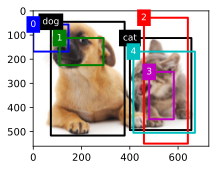

In [58]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

* 使用上面定义的`multibox_target`函数，我们可以[**根据狗和猫的真实边界框，标注这些锚框的分类和偏移量**]。  
* 在这个例子中，背景、狗和猫的类索引分别为0、1和2。
* 下面我们为锚框和真实边界框样本添加一个维度。


In [59]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

* 返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类别。
* 让我们根据图像中的锚框和真实边界框的位置来分析下面返回的类别标签。
  * 首先，在所有的锚框和真实边界框配对中，锚框$A_4$与猫的真实边界框的IoU是最大的。
  * 因此，$A_4$的类别被标记为猫。
  * 去除包含$A_4$或猫的真实边界框的配对，在剩下的配对中，锚框$A_1$和狗的真实边界框有最大的IoU。
  * 因此，$A_1$的类别被标记为狗。
  * 接下来，我们需要遍历剩下的三个未标记的锚框：$A_0$、$A_2$和$A_3$。
  * 对于$A_0$，与其拥有最大IoU的真实边界框的类别是狗，但IoU低于预定义的阈值（0.5），因此该类别被标记为背景；
  * 对于$A_2$，与其拥有最大IoU的真实边界框的类别是猫，IoU超过阈值，所以类别被标记为猫；
  * 对于$A_3$，与其拥有最大IoU的真实边界框的类别是猫，但值低于阈值，因此该类别被标记为背景。

In [66]:
labels

(tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
           2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
          -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
           4.17e-06,  6.26e-01]]),
 tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
          1., 1.]]),
 tensor([[0, 1, 2, 0, 2]]))

In [67]:
labels[2] # 各 img 下，各 anchor box 的 class label

tensor([[0, 1, 2, 0, 2]])

返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。
掩码变量中的元素与每个锚框的4个偏移量一一对应。
由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。
通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。


In [14]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

返回的第一个元素包含了为每个锚框标记的四个偏移值。
请注意，负类锚框的偏移量被标记为零。


In [15]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## 使用非极大值抑制预测边界框

* 在预测时，我们先为图像生成多个锚框，再为这些锚框一一预测类别和偏移量。
* 一个“预测好的边界框”则根据其中某个带有预测偏移量的锚框而生成。
* 下面我们实现了`offset_inverse`函数，该函数将锚框和偏移量预测作为输入，并[**应用逆偏移变换来返回预测的边界框坐标**]。

In [68]:
#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。
为了简化输出，我们可以使用*非极大值抑制*（non-maximum suppression，NMS）合并属于同一目标的类似的预测边界框。

以下是非极大值抑制的工作原理。
对于一个预测边界框$B$，目标检测模型会计算每个类别的预测概率。
假设最大的预测概率为$p$，则该概率所对应的类别$B$即为预测的类别。
具体来说，我们将$p$称为预测边界框$B$的*置信度*（confidence）。
在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表$L$。然后我们通过以下步骤操作排序列表$L$：

1. 从$L$中选取置信度最高的预测边界框$B_1$作为基准，然后将所有与$B_1$的IoU超过预定阈值$\epsilon$的非基准预测边界框从$L$中移除。这时，$L$保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有*非极大值*置信度的边界框被*抑制*了。
1. 从$L$中选取置信度第二高的预测边界框$B_2$作为又一个基准，然后将所有与$B_2$的IoU大于$\epsilon$的非基准预测边界框从$L$中移除。
1. 重复上述过程，直到$L$中的所有预测边界框都曾被用作基准。此时，$L$中任意一对预测边界框的IoU都小于阈值$\epsilon$；因此，没有一对边界框过于相似。
1. 输出列表$L$中的所有预测边界框。

[**以下`nms`函数按降序对置信度进行排序并返回其索引**]。


In [69]:
#@save
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

我们定义以下`multibox_detection`函数来[**将非极大值抑制应用于预测边界框**]。
如果你发现实现有点复杂，请不要担心。我们将在实现之后，马上用一个具体的例子来展示它是如何工作的。


In [70]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

现在让我们[**将上述算法应用到一个带有四个锚框的具体示例中**]。
为简单起见，我们假设预测的偏移量都是零，这意味着预测的边界框即是锚框。
对于背景、狗和猫其中的每个类，我们还定义了它的预测概率。


In [71]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

我们可以[**在图像上绘制这些预测边界框和置信度**]。


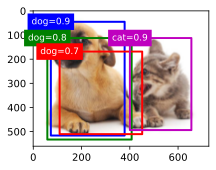

In [72]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

现在我们可以调用`multibox_detection`函数来执行非极大值抑制，其中阈值设置为0.5。
请注意，我们在示例的张量输入中添加了维度。

我们可以看到[**返回结果的形状是（批量大小，锚框的数量，6）**]。
最内层维度中的六个元素提供了同一预测边界框的输出信息。
第一个元素是预测的类索引，从0开始（0代表狗，1代表猫），值-1表示背景或在非极大值抑制中被移除了。
第二个元素是预测的边界框的置信度。
其余四个元素分别是预测边界框左上角和右下角的$(x, y)$轴坐标（范围介于0和1之间）。


In [73]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

删除-1类别（背景）的预测边界框后，我们可以[**输出由非极大值抑制保存的最终预测边界框**]。


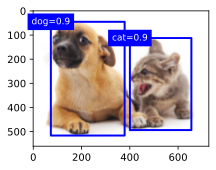

In [74]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，在执行非极大值抑制前，我们甚至可以将置信度较低的预测边界框移除，从而减少此算法中的计算量。
我们也可以对非极大值抑制的输出结果进行后处理。例如，只保留置信度更高的结果作为最终输出。

## 小结

* 我们以图像的每个像素为中心生成不同形状的锚框。
* 交并比（IoU）也被称为杰卡德系数，用于衡量两个边界框的相似性。它是相交面积与相并面积的比率。
* 在训练集中，我们需要给每个锚框两种类型的标签。一个是与锚框中目标检测的类别，另一个是锚框真实相对于边界框的偏移量。
* 在预测期间，我们可以使用非极大值抑制（NMS）来移除类似的预测边界框，从而简化输出。

## 练习

1. 在`multibox_prior`函数中更改`sizes`和`ratios`的值。生成的锚框有什么变化？
1. 构建并可视化两个IoU为0.5的边界框。它们是怎样重叠的？
1. 在 :numref:`subsec_labeling-anchor-boxes`和 :numref:`subsec_predicting-bounding-boxes-nms`中修改变量`anchors`，结果如何变化？
1. 非极大值抑制是一种贪心算法，它通过*移除*来抑制预测的边界框。是否存在一种可能，被移除的一些框实际上是有用的？如何修改这个算法来柔和地抑制？你可以参考Soft-NMS :cite:`Bodla.Singh.Chellappa.ea.2017`。
1. 如果非手动，非最大限度的抑制可以被学习吗？


[Discussions](https://discuss.d2l.ai/t/2946)
